In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
import quandl
quandl.ApiConfig.api_key = "***"

In [3]:
stocks = {
    'Tencent': 'HKEX/00700',
    'CKLife': 'HKEX/00775',
    'Waison': 'HKEX/03393',
    'Cowell': 'HKEX/01415'
}

In [4]:
def make_quandl_df(stocks):
    df = pd.DataFrame()
    for stock in stocks.keys():
        stock_df = quandl.get(stocks[stock])
        df[stock] = stock_df['Nominal Price']
    return df

In [5]:
hk_stocks = make_quandl_df(stocks)

In [74]:
class Portfolio():
    def __init__(self, cash, df, start_date, initial_holdings):
        self.price_history = df.loc[start_date:]
        self.stocks = list(self.price_history.columns)
        self.price_history[self.stocks] = self.price_history[self.stocks].fillna(method='pad')
        self.holdings_history = pd.DataFrame(0, columns = list(self.price_history.columns) , index=self.price_history.index)
        self.holdings_history['cash'] = cash
        self.initial_holdings = init_h
        self.trade_history = []
        self.latest_date = self.price_history.tail(1).index[0]
#         self.stocks.remove('cash')
        
    @property
    def data(self):
        trade_df = pd.DataFrame(self.trade_history).set_index('datetime')
        full_df = self.price_history.join(trade_df, how='outer').rename_axis('Date')
        
        full_df.loc[:,'portfolio_value'] = full_df.apply(lambda x:self.value_at_date(x.name), axis=1)
        return full_df

    @property
    def current_value(self):
        holdings_value = 0
        for stock in self.stocks:
            price = self.price_history.loc[self.latest_date, stock]
            quantity = self.holdings_history.loc[self.latest_date, stock]
            holdings_value += price*quantity
        return holdings_value + self.holdings_history.loc[self.latest_date,'cash']
    
    def value_at_date(self, date):
        holdings_value = 0
        for stock in  self.stocks:
            price = self.price_history.loc[date, stock]
            quantity = self.holdings_history.loc[date, stock]
            holdings_value += price*quantity
        return holdings_value + self.holdings_history.loc[date,'cash']


In [75]:
class Strategy(Portfolio):
    def __init__(self, cash, df, start_date, initial_holdings):
        super().__init__(cash, df, start_date, initial_holdings)
        
        for k in initial_holdings.keys():
            trade_price = self.price_history.loc[start_date, k]
            trade_value = round(initial_holdings[k] * trade_price, 2)
            self.holdings_history.loc[start_date:,'cash'] -= trade_value
            self.holdings_history.loc[start_date:, k] += initial_holdings[k]
            
    def make_trade(self, trade_date, quantity, asset):
        
        trade_price = self.price_history.loc[trade_date, asset]
        trade_value = round(quantity * trade_price, 2)
        self.holdings_history.loc[trade_date:,'cash'] -= trade_value

        trade = {'datetime': pd.to_datetime(trade_date),
                 'quantity': quantity,
                 'asset': asset,
                 'trade_value': trade_value}
        
        self.trade_history.append(trade)
        self.holdings_history.loc[trade_date:, asset] += quantity
        
        
    def make_random_trades(self,n):
        
        for i in range(n):
            trade_date = np.random.choice(self.price_history.index)
            trade_proportion = np.random.random() * 3/4 + .25
            trade_type = np.random.choice(['buy', 'sell'])

            if trade_type == 'buy':

                trade_asset = np.random.choice(self.stocks)
                trade_theoretical_amount = trade_proportion * self.holdings_history.loc[trade_date,'cash']
                trade_price = self.price_history.loc[trade_date, trade_asset]
                quantity = trade_theoretical_amount//trade_price
                rt = (trade_date, quantity, trade_asset)

            if trade_type == 'sell':

                trade_asset = np.random.choice(self.stocks)
                trade_price = self.price_history.loc[trade_date, trade_asset]
                quantity = round(self.holdings_history.loc[trade_date, trade_asset] * trade_proportion) * -1
                rt = (trade_date, quantity, trade_asset)

            self.make_trade(*rt)

In [76]:
init_h = {
            'Tencent': 120,
            'CKLife': 9000,
            'Waison': 1500,
            'Cowell': 800
        }

In [77]:
s = Strategy(100000, hk_stocks, '2018-01-02', init_h)

In [78]:
s.value_at_date('2018-01-03')

100670.0

In [79]:
s.make_random_trades(15)

In [80]:
s.data[s.data['Cowell'].isna()]

,Tencent,CKLife,Waison,Cowell,quantity,asset,trade_value,portfolio_value
Date,,,,,,,,


In [83]:
s.data.to_csv('bt_app/hk_stocks.csv')

In [84]:
s.data

,Tencent,CKLife,Waison,Cowell,quantity,asset,trade_value,portfolio_value
Date,,,,,,,,
2018-01-02,417.8,0.60,3.82,2.80,NaN,NaN,NaN,100000.00
2018-01-03,422.2,0.60,3.92,2.79,NaN,NaN,NaN,100670.00
2018-01-04,431.8,0.59,4.11,2.77,NaN,NaN,NaN,102001.00
2018-01-05,433.2,0.61,4.14,2.72,NaN,NaN,NaN,102354.00
2018-01-08,438.6,0.60,4.07,2.68,NaN,NaN,NaN,102775.00
...,...,...,...,...,...,...,...,...
2020-04-02,379.8,0.96,2.51,1.89,NaN,NaN,NaN,117923.04
2020-04-03,376.4,0.93,2.51,1.86,-374.0,Cowell,-695.64,114710.40
2020-04-06,381.4,0.95,2.48,1.90,NaN,NaN,NaN,117431.53


In [82]:
s.data['portfolio_value'][s.data['portfolio_value'].isna()]

Series([], Name: portfolio_value, dtype: float64)

In [85]:
s.data.loc['2018-02-07']

Tencent              414.8
CKLife                0.59
Waison                3.96
Cowell                 2.2
quantity               NaN
asset                  NaN
trade_value            NaN
portfolio_value    97458.4
Name: 2018-02-07 00:00:00, dtype: object

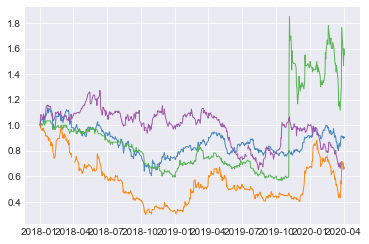

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

cols = list(s.data.columns[:4])
 
# multiple line plot
num=0
for column in cols:
    num+=1
    plt.plot(s.data.index, s.data[column]/s.data[column][0], marker='', color=palette(num), linewidth=1, alpha=0.9)

In [124]:
s.data['tencent'][0]

417.8

In [172]:
def make_fake_column(n, S0):
    data = [S0]
    for i in range(n):
        mu, sigma = .1, .1 # mean and standard deviation
        s = np.random.normal(mu, sigma, 1)
        current = data[i-1] + s[0]
        data.append(current)
    return data

In [35]:
import datetime

In [45]:
base = datetime.datetime.today()
date_list = [(base - datetime.timedelta(days=x)).strftime("%Y-%m-%d") for x in range(1500)]

In [2]:
import pandas as pd

In [5]:
results = pd.read_csv("bt_app/hk_stocks.csv")

In [13]:
results[['Tencent','CKLife', 'Waison', 'Cowell']] = results[['Tencent','CKLife', 'Waison', 'Cowell']].fillna(method='pad')

In [14]:
results[results['Waison'].isna()]

,Date,Tencent,CKLife,Waison,Cowell,quantity,asset,trade_value,portfolio_value


In [15]:
results[results['Cowell'].isna()]

,Date,Tencent,CKLife,Waison,Cowell,quantity,asset,trade_value,portfolio_value
